# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import sklearn.metrics
import sklearn.linear_model
from sklearn.feature_selection import RFE

import wrangle_zillow as wr
import preprocessing as pr
import explore as ex
import evaluate as ev
import model as mo

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

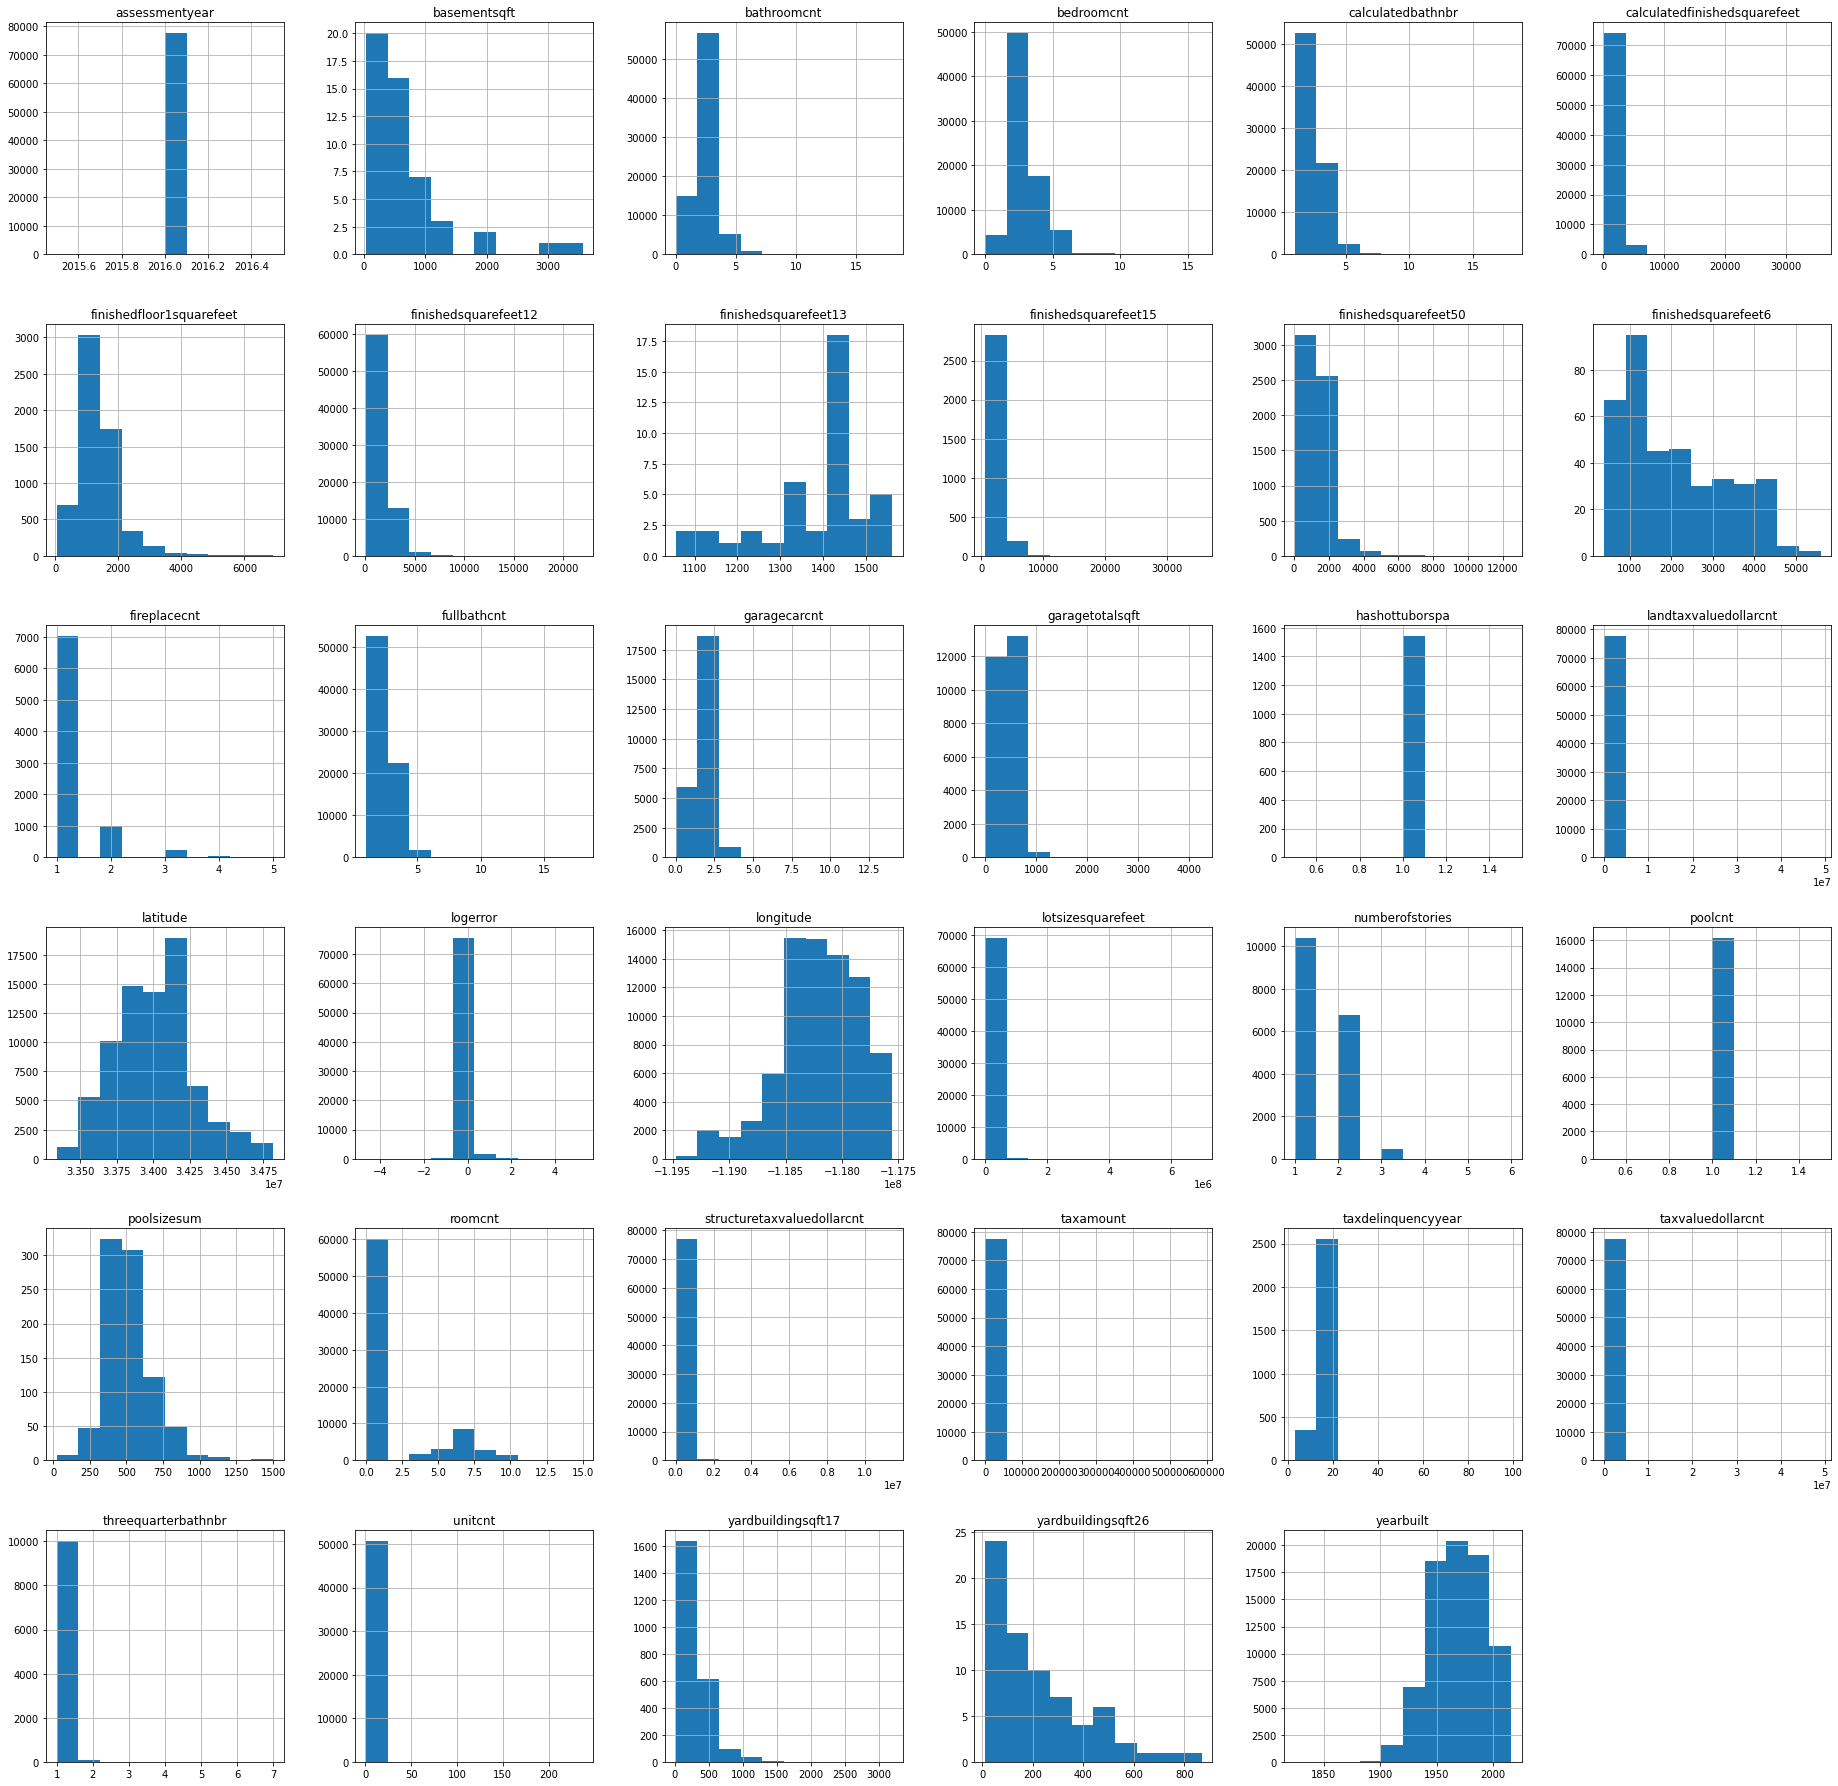

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

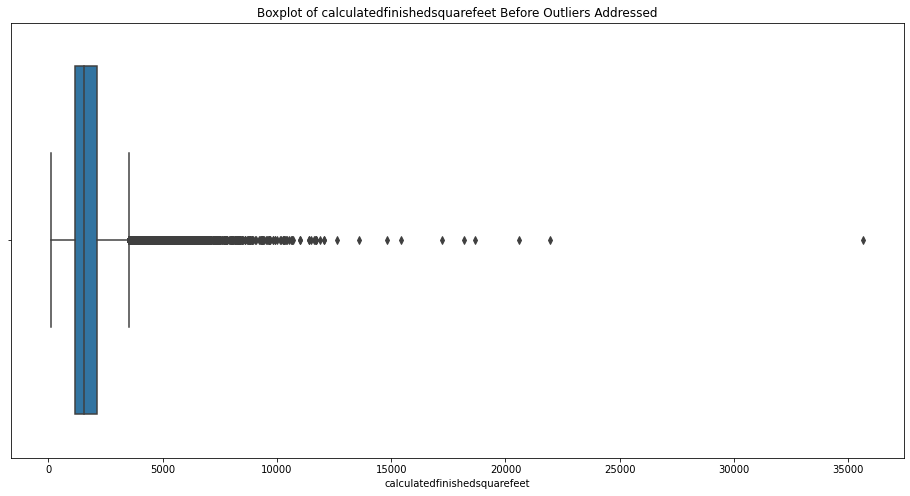

In [6]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.calculatedfinishedsquarefeet)
plt.title("Boxplot of calculatedfinishedsquarefeet Before Outliers Addressed")
plt.show()

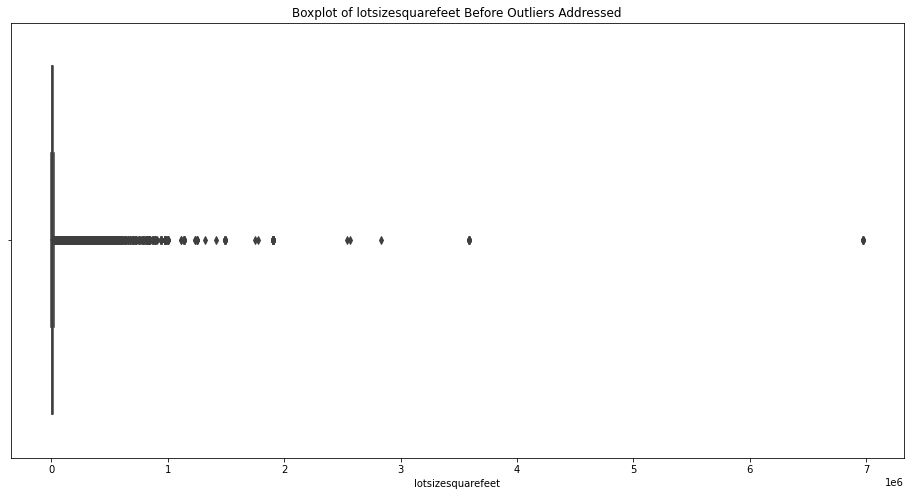

In [7]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.lotsizesquarefeet)
plt.title("Boxplot of lotsizesquarefeet Before Outliers Addressed")
plt.show()

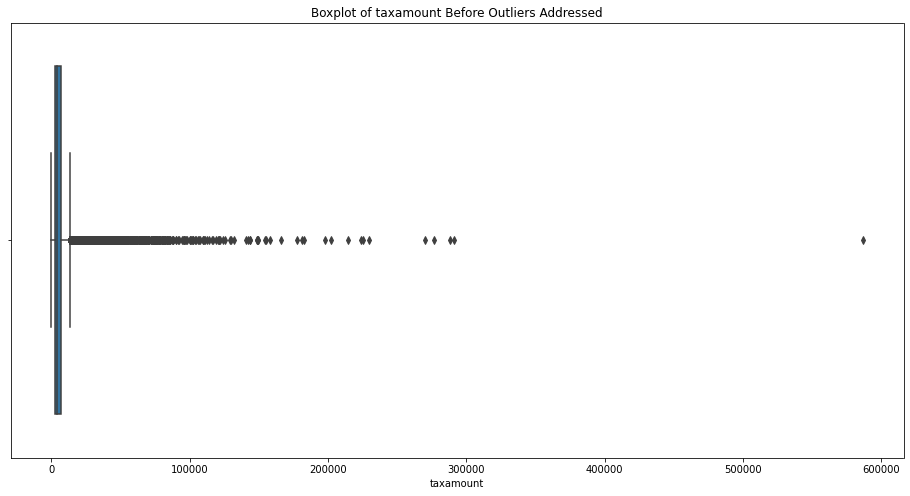

In [8]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.taxamount)
plt.title("Boxplot of taxamount Before Outliers Addressed")
plt.show()

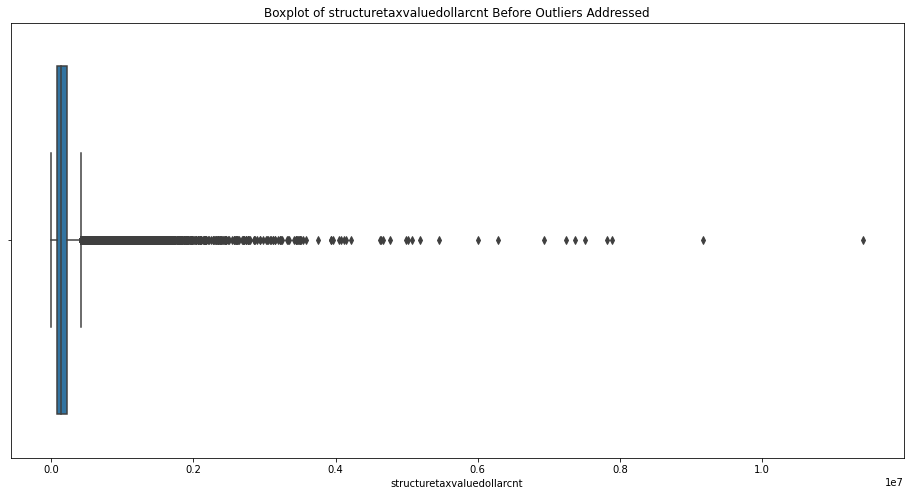

In [9]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.structuretaxvaluedollarcnt)
plt.title("Boxplot of structuretaxvaluedollarcnt Before Outliers Addressed")
plt.show()

> **Now that we have a general idea of what our data looks like and where outliers need to be addressed, let's move into preparation.**

---
# Prepare

## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county`, `tax_rate`, `yard_size`, and `price_per_sq_ft` variables
7. Detects and removes outliers
8. Resets the index of the DataFrame
9. Drops former index column

In [10]:
df = wr.prep_zillow(df)
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns after preparing the data.")
df.head()

Our DataFrame has 44440 rows and 33 columns after preparing the data.


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential,Orange County,0.010763,1406.0,330.090968
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential,Ventura County,0.012225,11182.0,316.723549
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential,Orange County,0.011488,7189.0,454.366854
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012247,10662.0,61.087121
4,12069064,1.0,2.0,5.0,1.0,738.0,6037.0,1.0,34149214.0,-118239357.0,4214.0,0100,6.037302e+07,45457.0,3101.0,96325.0,0.0,1.0,1922.0,18890.0,218552.0,2016.0,199662.0,2366.08,6.037302e+13,0.101723,2017-01-01,None,Single Family Residential,Los Angeles County,0.010826,3476.0,296.140921


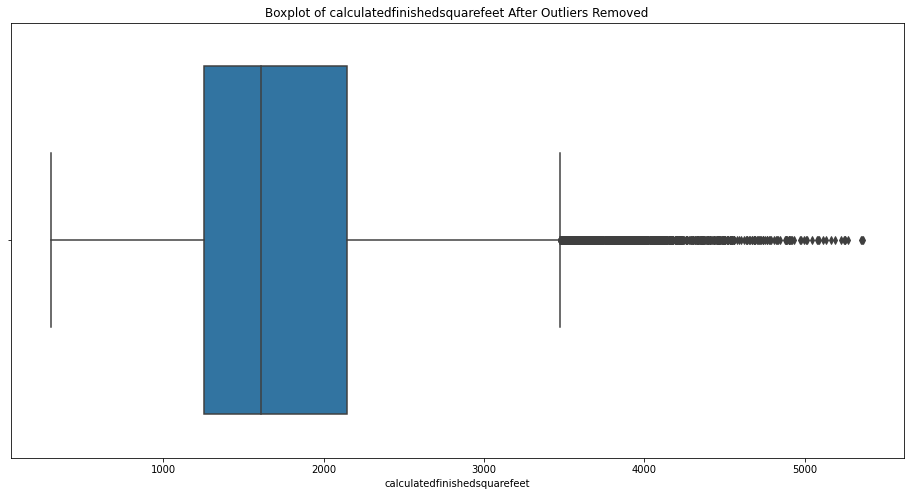

In [11]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.calculatedfinishedsquarefeet)
plt.title("Boxplot of calculatedfinishedsquarefeet After Outliers Removed")
plt.show()

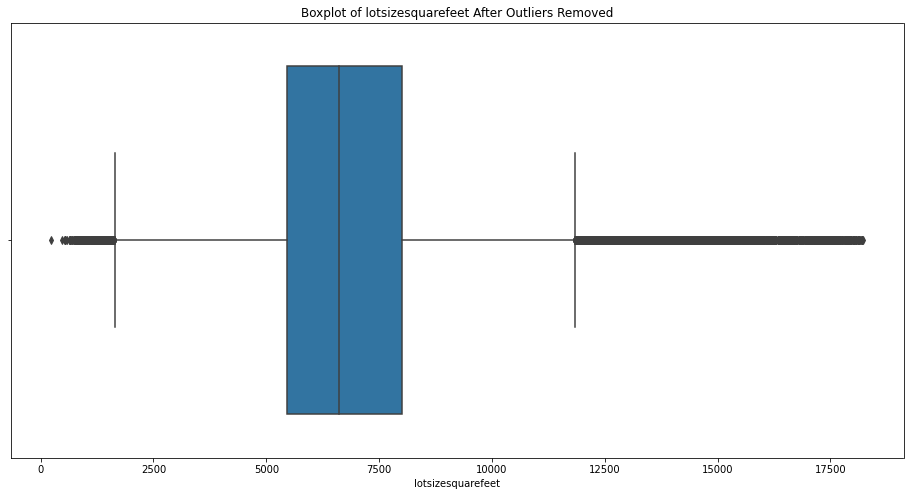

In [12]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.lotsizesquarefeet)
plt.title("Boxplot of lotsizesquarefeet After Outliers Removed")
plt.show()

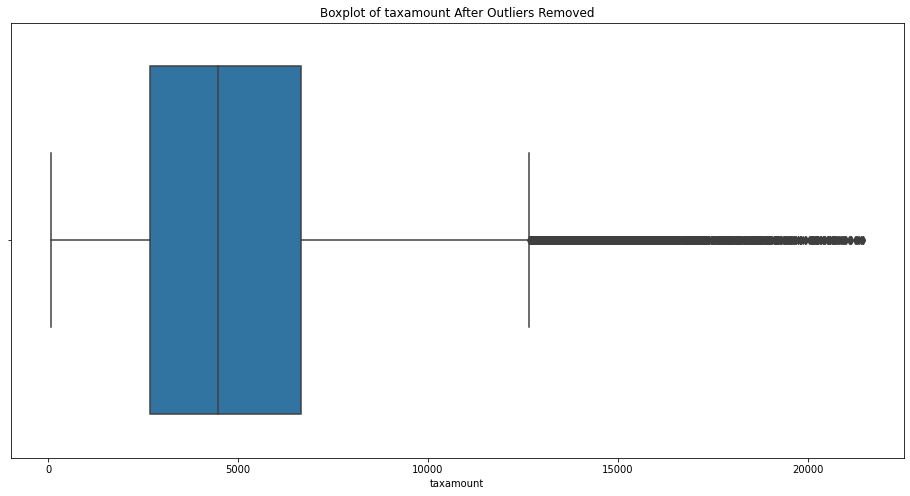

In [13]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.taxamount)
plt.title("Boxplot of taxamount After Outliers Removed")
plt.show()

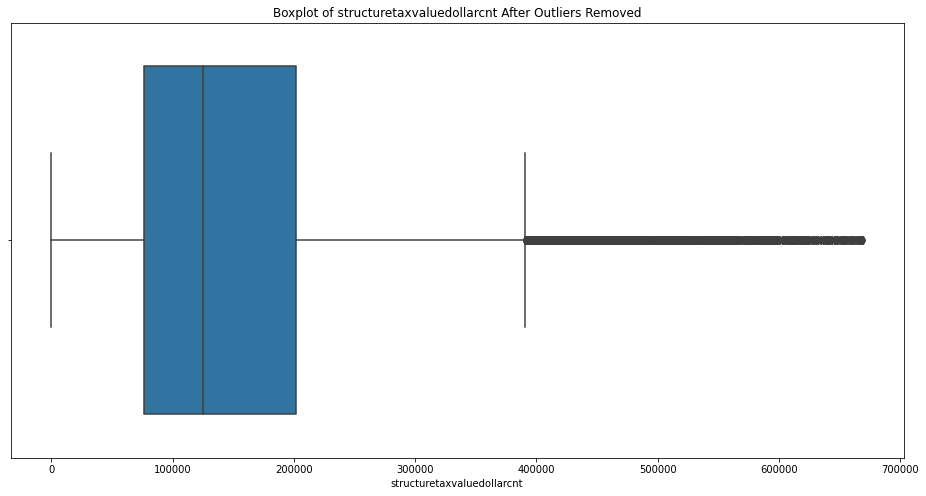

In [14]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.structuretaxvaluedollarcnt)
plt.title("Boxplot of structuretaxvaluedollarcnt After Outliers Removed")
plt.show()

> Looks like the outliers have been handled.

## Preprocessing

### Explanation of `split_impute_scale` function
The function does the following:
1. Splits prepared DataFrame into `train`, `validate`, and `test`
2. KNN imputes the regionidcity for `train`, `validate`, and `test`
3. Scales all appropriate numeric fields for `train`, `validate`, and `test`
4. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [15]:
imputer, scaler, train, validate, test = pr.split_impute_scale(df)
imputer

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [16]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
print(f"Our train DataFrame has {train.shape[0]} rows and {train.shape[1]} columns after preprocessing.")
print(f"Our validate DataFrame has {validate.shape[0]} rows and {validate.shape[1]} columns after preprocessing.")
print(f"Our test DataFrame has {test.shape[0]} rows and {test.shape[1]} columns after preprocessing.")

Our train DataFrame has 26664 rows and 33 columns after preprocessing.
Our validate DataFrame has 8888 rows and 33 columns after preprocessing.
Our test DataFrame has 8888 rows and 33 columns after preprocessing.


In [18]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft
35915,12457622,0.0,0.333333,0.2,0.0,0.196721,6037,0.0,0.372619,0.663738,0.390181,0100,0.006367,46298,3101,96239,0.000000,0.0,0.328467,0.100685,0.123589,0.0,0.122217,0.139519,0.006367,0.639213,2017-07-31,Floor/Wall,Single Family Residential,Los Angeles County,0.494151,0.444233,0.182773
40456,12906513,0.2,0.333333,0.5,0.2,0.191389,6037,0.2,0.557788,0.876809,0.415971,0100,0.004048,39308,3101,96494,0.000000,0.0,0.620438,0.154533,0.074533,0.0,0.031406,0.086354,0.004048,0.638314,2017-08-25,Central,Single Family Residential,Los Angeles County,0.500428,0.473054,0.111496
13143,14023137,0.2,0.333333,0.5,0.2,0.223385,6059,0.2,0.268013,0.825818,0.311512,122,0.297302,47568,1286,97004,0.583333,0.0,0.642336,0.071548,0.037447,0.0,0.022059,0.051657,0.297302,0.633058,2017-04-04,None,Single Family Residential,Orange County,0.614679,0.353183,0.046645
5357,11459439,0.2,0.500000,0.3,0.2,0.256962,6037,0.2,0.456542,0.550515,0.298815,0100,0.002372,12447,3101,96026,0.000000,0.0,0.510949,0.210432,0.398417,0.0,0.433715,0.425683,0.002372,0.632350,2017-02-13,Floor/Wall,Single Family Residential,Los Angeles County,0.463512,0.329661,0.480345
21808,11461483,0.0,0.333333,0.5,0.0,0.194549,6037,0.0,0.452833,0.547211,0.243679,0100,0.002373,12447,3101,96026,0.000000,0.0,0.510949,0.298840,0.406335,0.0,0.401818,0.431475,0.002373,0.638097,2017-05-22,Floor/Wall,Single Family Residential,Los Angeles County,0.458386,0.290300,0.614044


In [19]:
train.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [20]:
validate.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [21]:
test.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26664 entries, 35915 to 44208
Data columns (total 33 columns):
parcelid                        26664 non-null object
bathroomcnt                     26664 non-null float64
bedroomcnt                      26664 non-null float64
buildingqualitytypeid           26664 non-null float64
calculatedbathnbr               26664 non-null float64
calculatedfinishedsquarefeet    26664 non-null float64
fips                            26664 non-null object
fullbathcnt                     26664 non-null float64
latitude                        26664 non-null float64
longitude                       26664 non-null float64
lotsizesquarefeet               26664 non-null float64
propertycountylandusecode       26664 non-null object
rawcensustractandblock          26664 non-null float64
regionidcity                    26664 non-null object
regionidcounty                  26664 non-null object
regionidzip                     26664 non-null object
roomcnt      

In [23]:
train.describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,tax_rate,yard_size,price_per_sq_ft
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.0,26664.000000,26664.000000,26664.000000,26664.0,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,0.235599,0.375281,0.506353,0.235610,0.290394,0.223192,0.483721,0.667710,0.369073,0.171338,0.166867,0.0,0.614816,0.232658,0.219352,0.0,0.185819,0.235188,0.171363,0.639572,0.506974,0.393719,0.240556
std,0.164639,0.145734,0.125317,0.164631,0.140015,0.161033,0.191289,0.188599,0.155072,0.281994,0.263833,0.0,0.162610,0.169416,0.161463,0.0,0.162575,0.161092,0.281993,0.023093,0.141135,0.152825,0.158046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.333333,0.500000,0.200000,0.188623,0.200000,0.347763,0.559738,0.281321,0.004059,0.000000,0.0,0.525547,0.113620,0.099747,0.0,0.057253,0.121221,0.004060,0.633759,0.423053,0.309653,0.122566
50%,0.200000,0.333333,0.500000,0.200000,0.257555,0.200000,0.476627,0.691754,0.345598,0.006766,0.000000,0.0,0.598540,0.186139,0.189161,0.0,0.149651,0.204950,0.006769,0.638018,0.469987,0.377479,0.223358
75%,0.400000,0.500000,0.500000,0.400000,0.362631,0.400000,0.608299,0.806844,0.425790,0.297008,0.416667,0.0,0.722628,0.301223,0.295778,0.0,0.266565,0.307096,0.297008,0.642504,0.554137,0.455428,0.326916
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


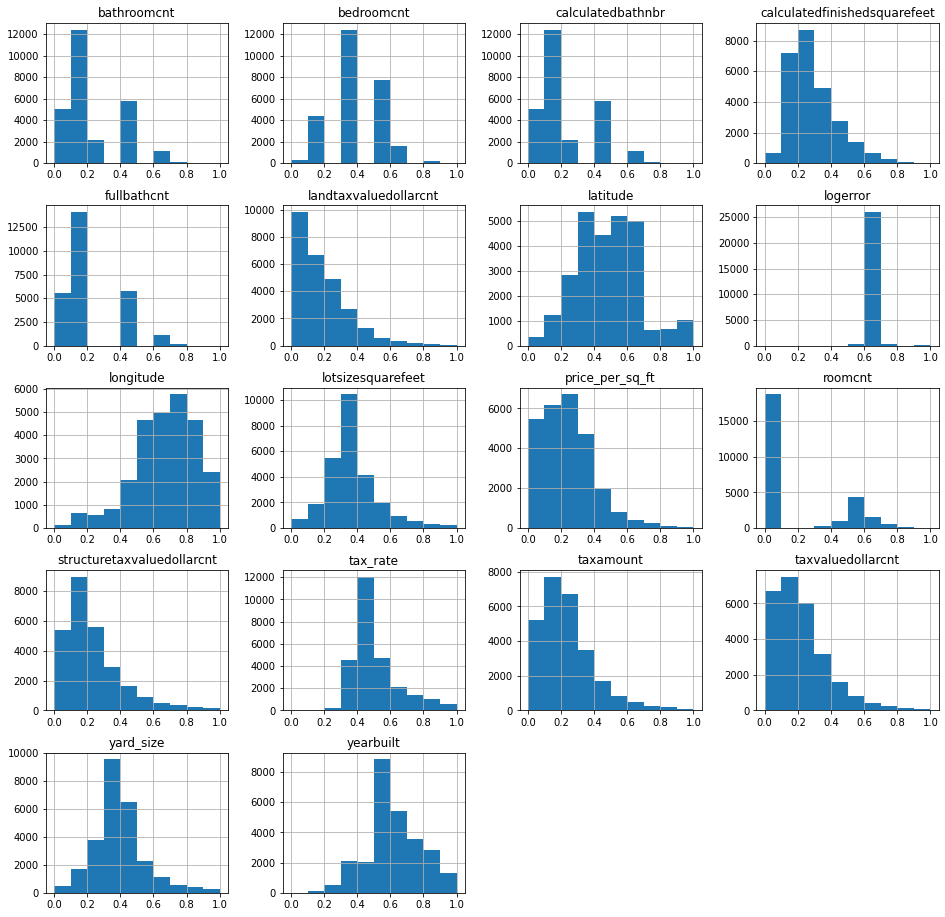

In [24]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

## Pairplot of Relevant Numeric Variables

In [25]:
sns.pairplot(data=train.drop(columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"]))

## Heatmap with Correlation Coefficients

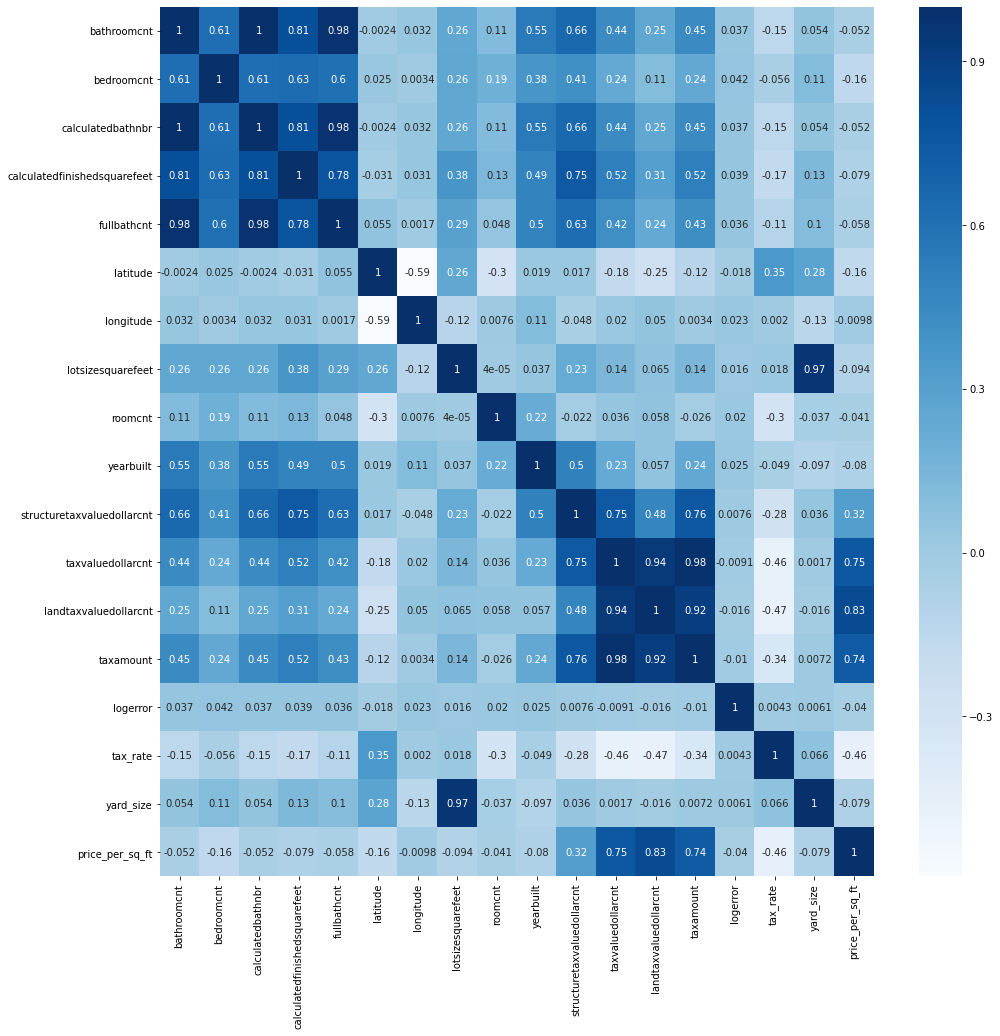

In [26]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [27]:
X = train[["logerror"]]

In [28]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6, random_state=56)
kmeans.fit(X)
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 5], dtype=int32)

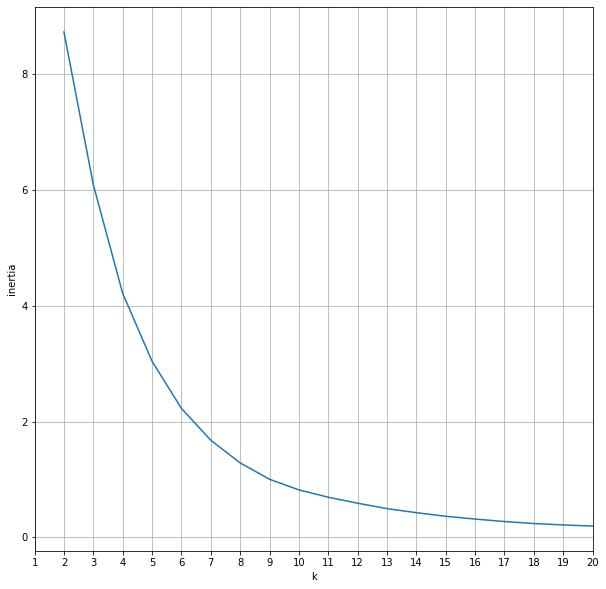

In [29]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

> **6 or 7 seem like reasonable values for k**

In [30]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7, random_state=56)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft,cluster_target
35915,12457622,0.0,0.333333,0.2,0.0,0.196721,6037,0.0,0.372619,0.663738,0.390181,0100,0.00636725,46298,3101,96239,0.000000,0,0.328467,0.100685,0.123589,0,0.122217,0.139519,0.00636725,0.639213,2017-07-31,Floor/Wall,Single Family Residential,Los Angeles County,0.494151,0.444233,0.182773,0
40456,12906513,0.2,0.333333,0.5,0.2,0.191389,6037,0.2,0.557788,0.876809,0.415971,0100,0.00404817,39308,3101,96494,0.000000,0,0.620438,0.154533,0.074533,0,0.031406,0.086354,0.00404817,0.638314,2017-08-25,Central,Single Family Residential,Los Angeles County,0.500428,0.473054,0.111496,0
13143,14023137,0.2,0.333333,0.5,0.2,0.223385,6059,0.2,0.268013,0.825818,0.311512,122,0.297302,47568,1286,97004,0.583333,0,0.642336,0.071548,0.037447,0,0.022059,0.051657,0.297302,0.633058,2017-04-04,None,Single Family Residential,Orange County,0.614679,0.353183,0.046645,5
5357,11459439,0.2,0.500000,0.3,0.2,0.256962,6037,0.2,0.456542,0.550515,0.298815,0100,0.00237173,12447,3101,96026,0.000000,0,0.510949,0.210432,0.398417,0,0.433715,0.425683,0.00237173,0.632350,2017-02-13,Floor/Wall,Single Family Residential,Los Angeles County,0.463512,0.329661,0.480345,5
21808,11461483,0.0,0.333333,0.5,0.0,0.194549,6037,0.0,0.452833,0.547211,0.243679,0100,0.00237309,12447,3101,96026,0.000000,0,0.510949,0.298840,0.406335,0,0.401818,0.431475,0.00237309,0.638097,2017-05-22,Floor/Wall,Single Family Residential,Los Angeles County,0.458386,0.290300,0.614044,0


In [31]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,logerror
0,0.640119
1,0.734406
2,0.576178
3,0.935394
4,0.667612
5,0.627212
6,0.313495


In [32]:
train.groupby("cluster_target")["logerror"].mean()

cluster_target
0    0.640097
1    0.734406
2    0.576014
3    0.935394
4    0.667560
5    0.627156
6    0.313495
Name: logerror, dtype: float64

> **There are two centroids for lower (0.31) and upper (0.94) outlier clusters. Generally, the centriods fall in between 0.58 and 0.73 indicating that most of the clusters are grouped close together**

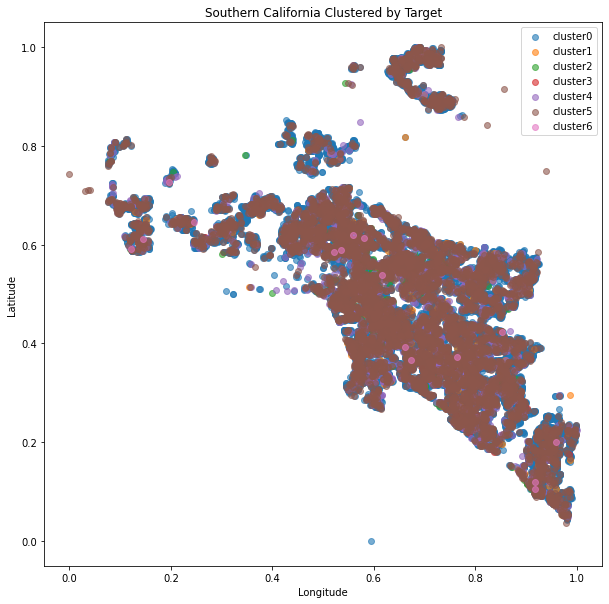

In [33]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("cluster_target"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

plt.legend()
plt.title("Southern California Clustered by Target")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

> **This visualization leads me to believe that the mean logerror by county is the same.**

$H_0$: The mean logerror by county is the same

$H_0$: The mean logerror by county is different

In [34]:
alpha = .001

la = train[train.county == "Los Angeles County"].logerror
orange = train[train.county == "Orange County"].logerror
ventura = train[train.county == "Ventura County"].logerror

f, p = stats.f_oneway(la, orange, ventura)
print(f"statistic = {f}")
print(f"  p-value = {p}")
print()
if p < alpha:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

statistic = 12.547312509598612
  p-value = 3.5754799354519303e-06

Reject null hypothesis


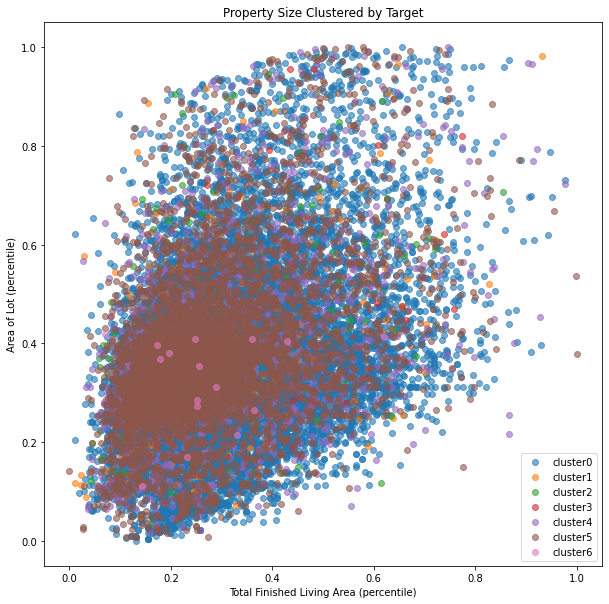

In [35]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("cluster_target"):
    plt.scatter(subset.calculatedfinishedsquarefeet, subset.lotsizesquarefeet, label="cluster" + str(cluster), alpha=.6)

plt.legend()
plt.title("Property Size Clustered by Target")
plt.xlabel("Total Finished Living Area (percentile)")
plt.ylabel("Area of Lot (percentile)")
plt.show()

## Cluster Independent Variables
### Cluster by Location

In [36]:
X = train[["latitude", "longitude"]]

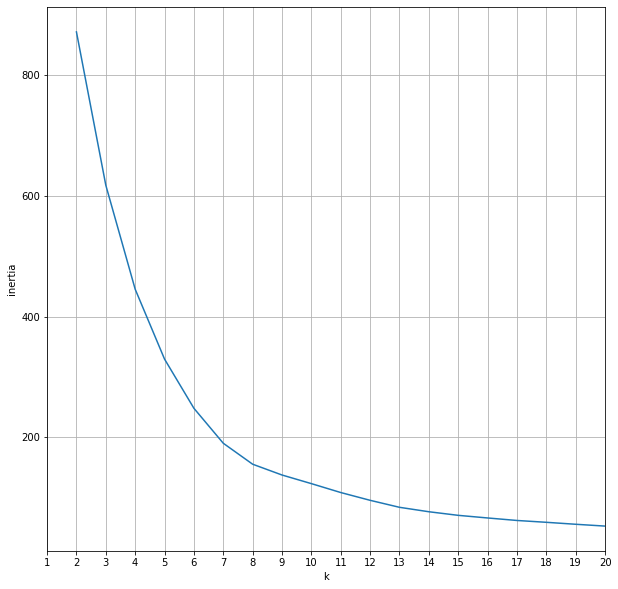

In [37]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [38]:
kmeans = KMeans(n_clusters=7, random_state=56)
kmeans.fit(X)
train["location_cluster"] = kmeans.predict(X)

In [39]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,latitude,longitude
0,0.649984,0.510755
1,0.426456,0.610320
2,0.341483,0.790435
3,0.653722,0.227249
4,0.536215,0.770393
5,0.943388,0.688179
6,0.181855,0.925043


In [40]:
train.groupby("location_cluster")["latitude", "longitude"].mean()

,latitude,longitude
location_cluster,,
0,0.650008,0.510766
1,0.426523,0.610165
2,0.341841,0.790233
3,0.653754,0.227466
4,0.536566,0.770360
5,0.943388,0.688179
6,0.181943,0.924920


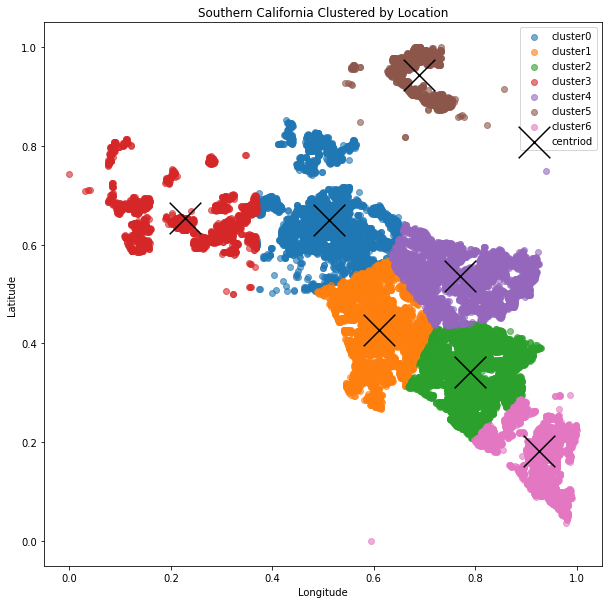

In [41]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("location_cluster"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="longitude", y="latitude", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    

plt.legend()
plt.title("Southern California Clustered by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

> Here we are able to see our properties clustered by geographic location.

---
### Cluster by Size

In [42]:
X = train[["calculatedfinishedsquarefeet", "lotsizesquarefeet"]]

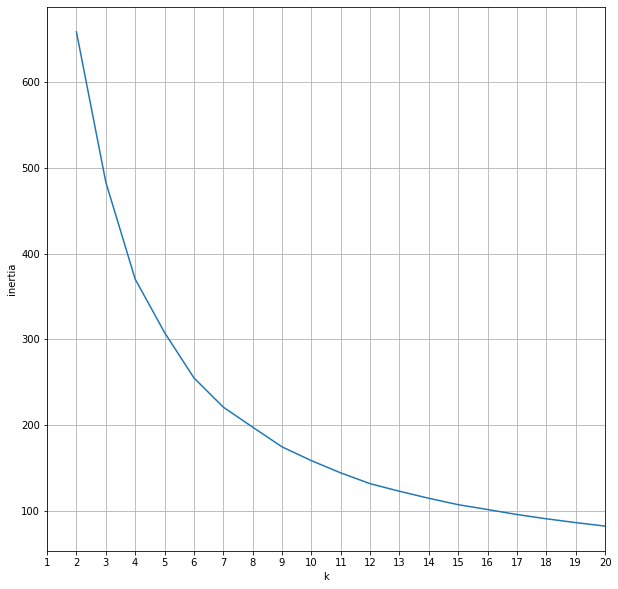

In [43]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [44]:
kmeans = KMeans(n_clusters=7, random_state=56)
kmeans.fit(X)
train["size_cluster"] = kmeans.predict(X)

In [45]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,calculatedfinishedsquarefeet,lotsizesquarefeet
0,0.212426,0.130393
1,0.247901,0.402051
2,0.599431,0.442987
3,0.179848,0.301371
4,0.504101,0.818030
5,0.401839,0.310245
6,0.325533,0.584959


In [46]:
train.groupby("size_cluster")["calculatedfinishedsquarefeet", "lotsizesquarefeet"].mean()

,calculatedfinishedsquarefeet,lotsizesquarefeet
size_cluster,,
0,0.212377,0.130279
1,0.247641,0.402511
2,0.599268,0.442477
3,0.180032,0.301369
4,0.504556,0.817980
5,0.401366,0.310356
6,0.325798,0.585272


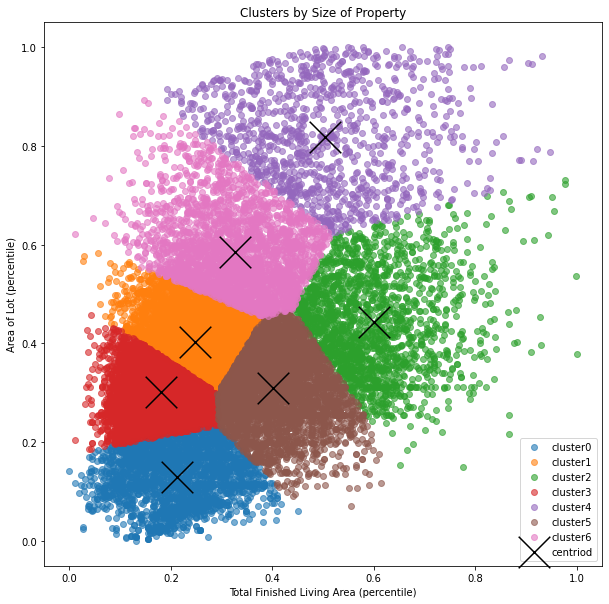

In [47]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("size_cluster"):
    plt.scatter(subset.calculatedfinishedsquarefeet, subset.lotsizesquarefeet, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="calculatedfinishedsquarefeet", y="lotsizesquarefeet", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    
    
plt.legend()
plt.title("Clusters by Size of Property")
plt.xlabel("Total Finished Living Area (percentile)")
plt.ylabel("Area of Lot (percentile)")
plt.show()

> Here we are able to see our properties clustered by size. 

---
### Cluster by Location & Size

In [48]:
X = train[["latitude", "longitude", "calculatedfinishedsquarefeet", "lotsizesquarefeet"]]

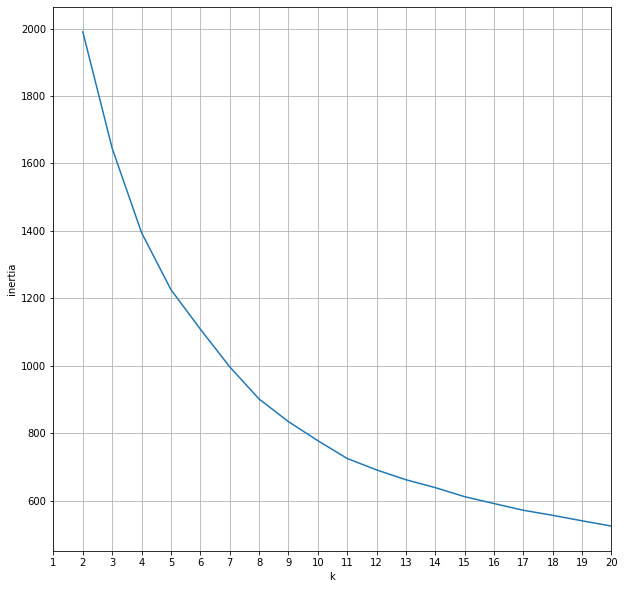

In [49]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [50]:
kmeans = KMeans(n_clusters=9, random_state=56)
kmeans.fit(X)
train["location_size_cluster"] = kmeans.predict(X)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft,cluster_target,location_cluster,size_cluster,location_size_cluster
35915,12457622,0.0,0.333333,0.2,0.0,0.196721,6037,0.0,0.372619,0.663738,0.390181,0100,0.00636725,46298,3101,96239,0.000000,0,0.328467,0.100685,0.123589,0,0.122217,0.139519,0.00636725,0.639213,2017-07-31,Floor/Wall,Single Family Residential,Los Angeles County,0.494151,0.444233,0.182773,0,1,1,2
40456,12906513,0.2,0.333333,0.5,0.2,0.191389,6037,0.2,0.557788,0.876809,0.415971,0100,0.00404817,39308,3101,96494,0.000000,0,0.620438,0.154533,0.074533,0,0.031406,0.086354,0.00404817,0.638314,2017-08-25,Central,Single Family Residential,Los Angeles County,0.500428,0.473054,0.111496,0,4,1,7
13143,14023137,0.2,0.333333,0.5,0.2,0.223385,6059,0.2,0.268013,0.825818,0.311512,122,0.297302,47568,1286,97004,0.583333,0,0.642336,0.071548,0.037447,0,0.022059,0.051657,0.297302,0.633058,2017-04-04,None,Single Family Residential,Orange County,0.614679,0.353183,0.046645,5,2,3,5
5357,11459439,0.2,0.500000,0.3,0.2,0.256962,6037,0.2,0.456542,0.550515,0.298815,0100,0.00237173,12447,3101,96026,0.000000,0,0.510949,0.210432,0.398417,0,0.433715,0.425683,0.00237173,0.632350,2017-02-13,Floor/Wall,Single Family Residential,Los Angeles County,0.463512,0.329661,0.480345,5,1,3,2
21808,11461483,0.0,0.333333,0.5,0.0,0.194549,6037,0.0,0.452833,0.547211,0.243679,0100,0.00237309,12447,3101,96026,0.000000,0,0.510949,0.298840,0.406335,0,0.401818,0.431475,0.00237309,0.638097,2017-05-22,Floor/Wall,Single Family Residential,Los Angeles County,0.458386,0.290300,0.614044,0,1,3,2


In [51]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,latitude,longitude,calculatedfinishedsquarefeet,lotsizesquarefeet
0,0.441129,0.792300,0.400072,0.666834
1,0.245399,0.870191,0.502449,0.371402
2,0.425814,0.639384,0.195199,0.271700
3,0.941658,0.687025,0.313851,0.411769
4,0.630566,0.534054,0.262902,0.372757
5,0.246508,0.863971,0.258777,0.205337
6,0.658302,0.218483,0.293312,0.354056
7,0.442530,0.790594,0.236828,0.381936
8,0.636798,0.467248,0.497642,0.641747


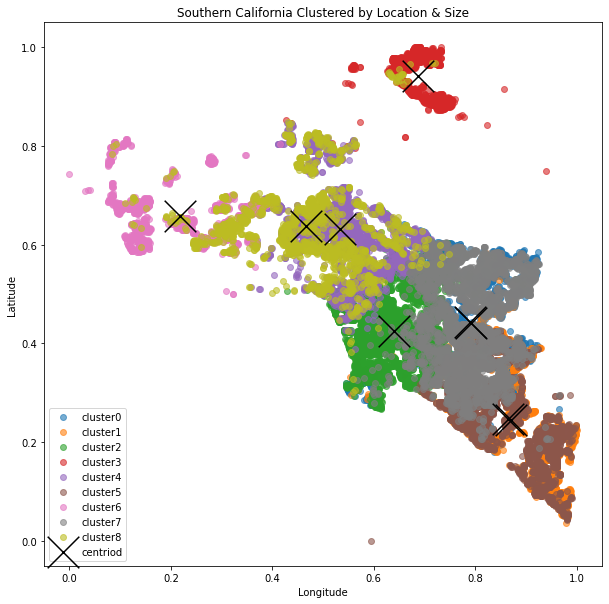

In [52]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("location_size_cluster"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="longitude", y="latitude", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    
    
plt.legend()
plt.title("Southern California Clustered by Location & Size")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

> This visulization is not very useful, but we'll keep it to document some exploration.

# Model

In [53]:
pd.options.display.float_format = '{:.3f}'.format

> Let's subset our data to experiment with different models

In [54]:
size_cluster0 = train[train.size_cluster == 0]
size_cluster1 = train[train.size_cluster == 1]
size_cluster2 = train[train.size_cluster == 2]
size_cluster3 = train[train.size_cluster == 3]
size_cluster4 = train[train.size_cluster == 4]
size_cluster5 = train[train.size_cluster == 5]
size_cluster6 = train[train.size_cluster == 6]

---
### Size Cluster 0, Model 1: logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate

In [55]:
cluster0_predictions = pd.DataFrame({
    "actual_logerror": size_cluster0.logerror,
    "baseline_logerror": size_cluster0.logerror.mean()
})

cluster0_predictions.head()

,actual_logerror,baseline_logerror
40766,0.631,0.640
29000,0.634,0.640
25538,0.638,0.640
5799,0.641,0.640
36499,0.640,0.640


In [56]:
X = size_cluster0[["price_per_sq_ft", "buildingqualitytypeid", "tax_rate"]]
# target
y = size_cluster0.logerror

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"] = lm.predict(X)
cluster0_predictions.head()

,actual_logerror,baseline_logerror,logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate
40766,0.631,0.640,0.639
29000,0.634,0.640,0.638
25538,0.638,0.640,0.640
5799,0.641,0.640,0.640
36499,0.640,0.640,0.641


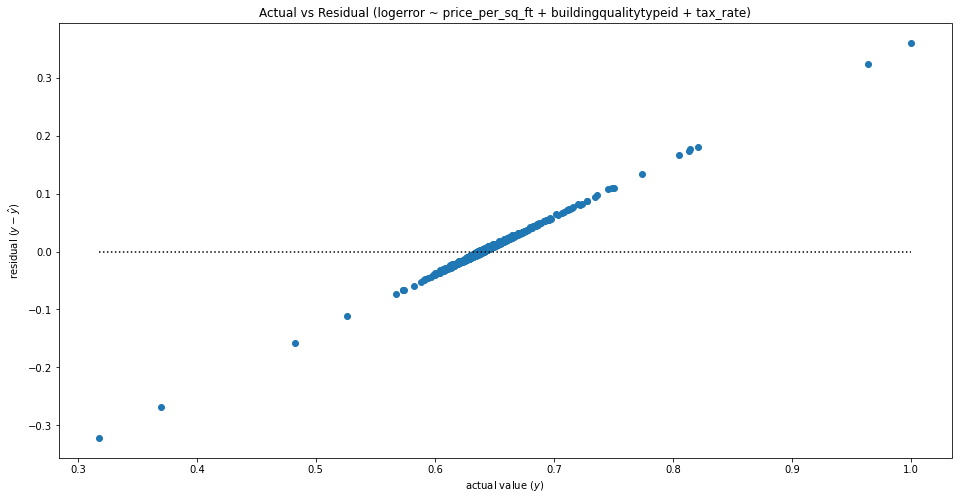

In [57]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [58]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * price_per_sq_ft) + ({lm.coef_[1]:.2f} * buildingqualitytypeid) + ({lm.coef_[-1]:.2f} * tax_rate) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (-0.01 * price_per_sq_ft) + (-0.00 * buildingqualitytypeid) + (0.00 * tax_rate) + 0.64


In [59]:
ev.regression_errors(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"], cluster0_predictions)


SSE    1.026
ESS    0.002
TSS    1.028
MSE    0.000
RMSE   0.020
dtype: float64

In [60]:
cluster0_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster0_predictions.actual_logerror, c)))


actual_logerror                                                 0.000
baseline_logerror                                               0.020
logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate   0.020
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [61]:
ev.better_than_baseline(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"], cluster0_predictions.baseline_logerror, cluster0_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

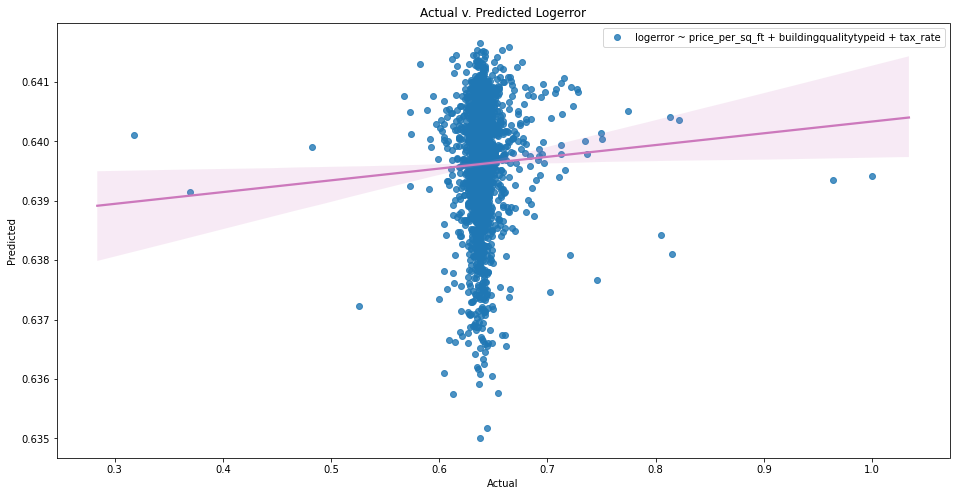

In [62]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster0_predictions.actual_logerror, y=cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"], data=cluster0_predictions, label="logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 0, Model 2: logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet¶

In [63]:
X = size_cluster0[["calculatedfinishedsquarefeet", "lotsizesquarefeet"]]
# target
y = size_cluster0.logerror

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"] = lm.predict(X)
cluster0_predictions.head()

,actual_logerror,baseline_logerror,logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate,logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet
40766,0.631,0.640,0.639,0.639
29000,0.634,0.640,0.638,0.639
25538,0.638,0.640,0.640,0.640
5799,0.641,0.640,0.640,0.639
36499,0.640,0.640,0.641,0.640


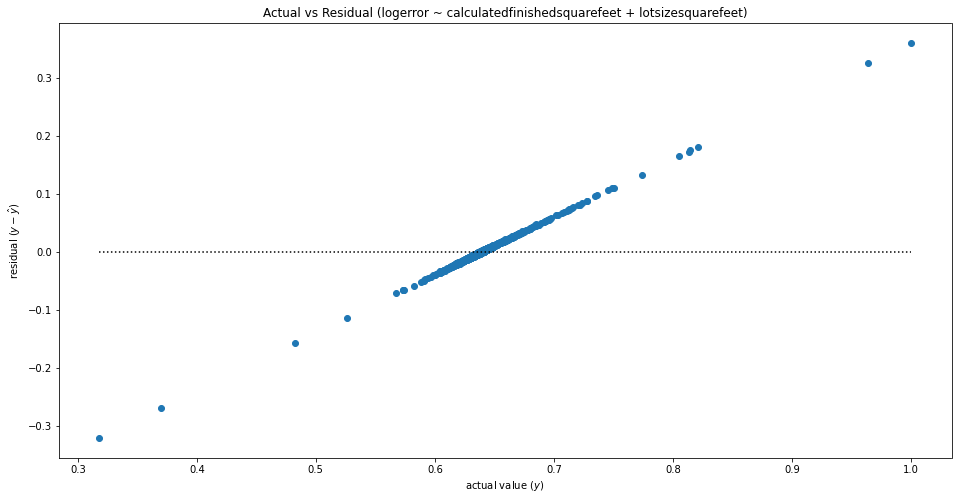

In [64]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [65]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * calculatedfinishedsquarefeet) + ({lm.coef_[1]:.2f} * lotsizesquarefeet) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (-0.01 * calculatedfinishedsquarefeet) + (-0.00 * lotsizesquarefeet) + 0.64


In [66]:
ev.regression_errors(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"], cluster0_predictions)


SSE    1.027
ESS    0.001
TSS    1.028
MSE    0.000
RMSE   0.020
dtype: float64

In [67]:
cluster0_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster0_predictions.actual_logerror, c)))


actual_logerror                                                 0.000
baseline_logerror                                               0.020
logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate   0.020
logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet     0.020
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [68]:
ev.better_than_baseline(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"], cluster0_predictions.baseline_logerror, cluster0_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

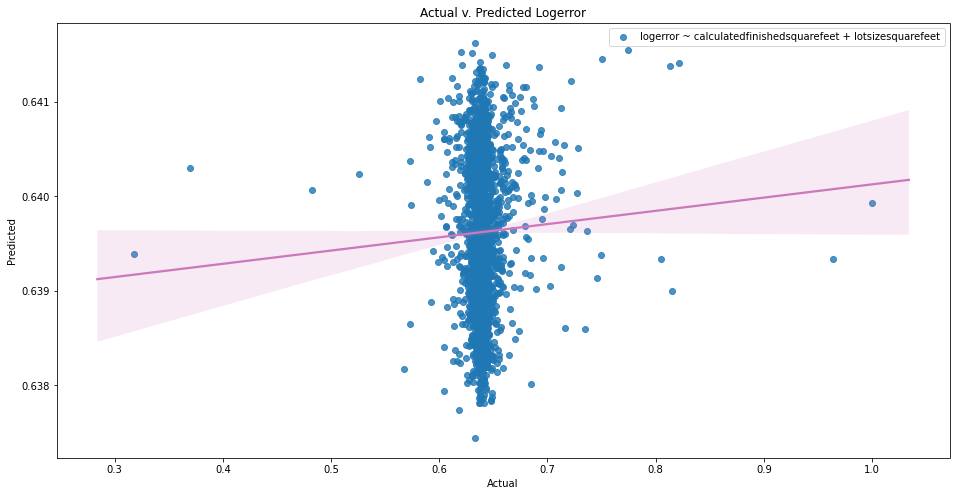

In [69]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster0_predictions.actual_logerror, y=cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"], data=cluster0_predictions, label="logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 0, Model 3: RFE

In [70]:
X = size_cluster0.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster0.logerror

In [71]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [72]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['calculatedfinishedsquarefeet', 'taxvaluedollarcnt'], dtype='object')


In [73]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.30535256, 0.27331862],
       [0.31226546, 0.5113972 ],
       [0.14734347, 0.10181994],
       ...,
       [0.15544144, 0.14946723],
       [0.34860754, 0.36325418],
       [0.19336362, 0.09247151]])

In [74]:
lm.fit(X_rfe, y)
cluster0_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster0_predictions

,actual_logerror,baseline_logerror,logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate,logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet,multiple_rfe
40766,0.631,0.640,0.639,0.639,0.639
29000,0.634,0.640,0.638,0.639,0.637
25538,0.638,0.640,0.640,0.640,0.641
5799,0.641,0.640,0.640,0.639,0.639
36499,0.640,0.640,0.641,0.640,0.641
...,...,...,...,...,...
31037,0.639,0.640,0.640,0.640,0.640
4040,0.645,0.640,0.640,0.639,0.639
36941,0.637,0.640,0.640,0.640,0.640
17093,0.645,0.640,0.639,0.638,0.638


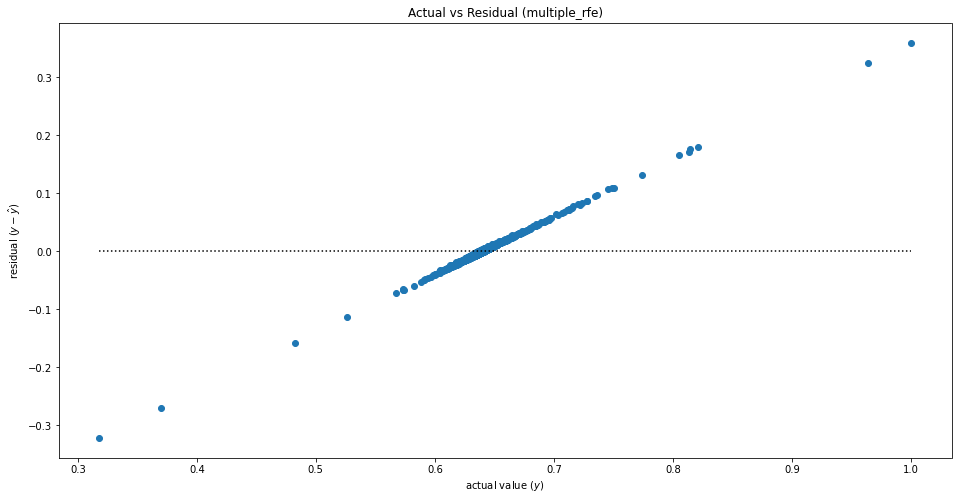

In [75]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster0_predictions.actual_logerror, cluster0_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [76]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (-0.01 * calculatedfinishedsquarefeet) + (-0.01 * taxvaluedollarcnt) + 0.64


In [77]:
ev.regression_errors(cluster0_predictions.actual_logerror, cluster0_predictions.multiple_rfe, cluster0_predictions)


SSE    1.026
ESS    0.002
TSS    1.028
MSE    0.000
RMSE   0.020
dtype: float64

In [78]:
cluster0_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster0_predictions.actual_logerror, c)))


actual_logerror                                                 0.000
baseline_logerror                                               0.020
logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate   0.020
logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet     0.020
multiple_rfe                                                    0.020
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [79]:
ev.better_than_baseline(cluster0_predictions.actual_logerror, cluster0_predictions.multiple_rfe, cluster0_predictions.baseline_logerror, cluster0_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

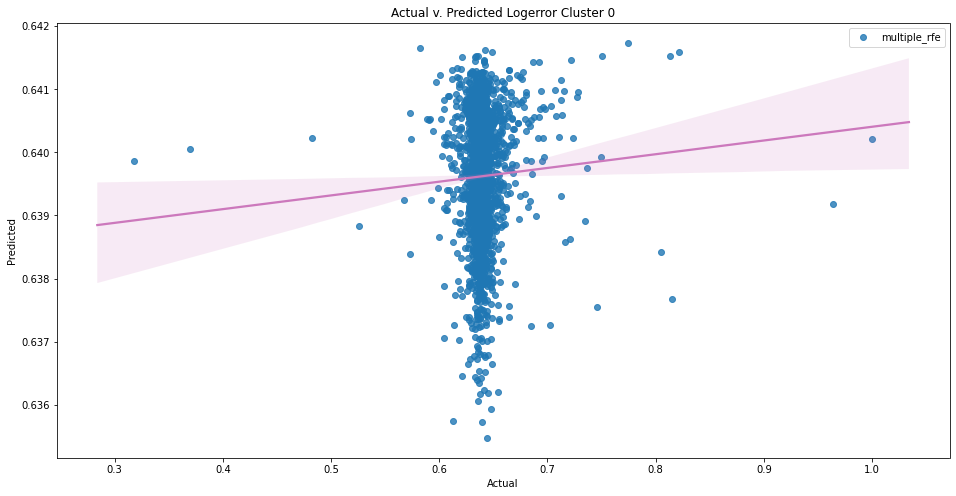

In [80]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster0_predictions.actual_logerror, y=cluster0_predictions.multiple_rfe, data=cluster0_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 0")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Evaluate Best Model On Test

In [81]:
X_test = test[["calculatedfinishedsquarefeet", "taxvaluedollarcnt"]]

test["yhat"] = lm.predict(X_test)
test.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft,yhat
43855,14204937,0.300,0.333,0.500,0.300,0.253,6059.000,0.200,0.373,0.901,0.291,122,0.297,16764.000,1286.000,97027.000,0.000,0.000,0.839,0.270,0.308,0.000,0.285,0.294,0.297,0.638,2017-09-14,None,Single Family Residential,Orange County,0.371,0.322,0.375,0.639
9787,13060520,0.400,0.667,0.700,0.400,0.409,6037.000,0.400,0.499,0.874,0.412,0100,0.004,24384.000,3101.000,96505.000,0.000,0.000,0.642,0.217,0.175,0.000,0.135,0.201,0.004,0.629,2017-03-15,Central,Single Family Residential,Los Angeles County,0.515,0.404,0.136,0.639
6617,11972981,0.200,0.500,0.500,0.200,0.167,6037.000,0.200,0.564,0.659,0.312,0100,0.001,12447.000,3101.000,96023.000,0.000,0.000,0.314,0.119,0.179,0.000,0.187,0.194,0.001,0.631,2017-02-23,Floor/Wall,Single Family Residential,Los Angeles County,0.467,0.370,0.303,0.640
12318,12044484,1.000,0.833,0.800,1.000,0.756,6037.000,1.000,0.616,0.614,0.312,0100,0.003,396054.000,3101.000,96433.000,0.000,0.000,0.956,0.983,0.601,0.000,0.332,0.582,0.003,0.675,2017-03-30,Central,Single Family Residential,Los Angeles County,0.385,0.192,0.273,0.634
8157,10990411,0.400,0.333,0.800,0.400,0.539,6037.000,0.400,0.653,0.578,0.984,0104,0.000,12447.000,3101.000,96282.000,0.000,0.000,0.788,0.663,0.395,0.000,0.212,0.420,0.000,0.645,2017-03-03,Central,Single Family Residential,Los Angeles County,0.460,0.968,0.245,0.637


In [82]:
test["yhat_baseline"] = test.logerror.mean()
test.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft,yhat,yhat_baseline
43855,14204937,0.300,0.333,0.500,0.300,0.253,6059.000,0.200,0.373,0.901,0.291,122,0.297,16764.000,1286.000,97027.000,0.000,0.000,0.839,0.270,0.308,0.000,0.285,0.294,0.297,0.638,2017-09-14,None,Single Family Residential,Orange County,0.371,0.322,0.375,0.639,0.639
9787,13060520,0.400,0.667,0.700,0.400,0.409,6037.000,0.400,0.499,0.874,0.412,0100,0.004,24384.000,3101.000,96505.000,0.000,0.000,0.642,0.217,0.175,0.000,0.135,0.201,0.004,0.629,2017-03-15,Central,Single Family Residential,Los Angeles County,0.515,0.404,0.136,0.639,0.639
6617,11972981,0.200,0.500,0.500,0.200,0.167,6037.000,0.200,0.564,0.659,0.312,0100,0.001,12447.000,3101.000,96023.000,0.000,0.000,0.314,0.119,0.179,0.000,0.187,0.194,0.001,0.631,2017-02-23,Floor/Wall,Single Family Residential,Los Angeles County,0.467,0.370,0.303,0.640,0.639
12318,12044484,1.000,0.833,0.800,1.000,0.756,6037.000,1.000,0.616,0.614,0.312,0100,0.003,396054.000,3101.000,96433.000,0.000,0.000,0.956,0.983,0.601,0.000,0.332,0.582,0.003,0.675,2017-03-30,Central,Single Family Residential,Los Angeles County,0.385,0.192,0.273,0.634,0.639
8157,10990411,0.400,0.333,0.800,0.400,0.539,6037.000,0.400,0.653,0.578,0.984,0104,0.000,12447.000,3101.000,96282.000,0.000,0.000,0.788,0.663,0.395,0.000,0.212,0.420,0.000,0.645,2017-03-03,Central,Single Family Residential,Los Angeles County,0.460,0.968,0.245,0.637,0.639


In [83]:
ev.regression_errors(test.logerror, test.yhat, test)

SSE    5.391
ESS    0.019
TSS    5.410
MSE    0.001
RMSE   0.025
dtype: float64

In [84]:
ev.baseline_errors(test.logerror, test.yhat_baseline, test)

SSE_baseline    5.369
MSE_baseline    0.001
RMSE_baseline   0.025
dtype: float64

In [85]:
print(f'Coefficient of determination, or explained variance: {sklearn.metrics.r2_score(test.logerror, test.yhat):.2f}')

Coefficient of determination, or explained variance: -0.00


In [86]:
ev.better_than_baseline(test.logerror, test.yhat, test.yhat_baseline, test)

Model does not predict better than baseline, and is therefore useless


---
### Size Cluster 1 Model: RFE

In [87]:
X = size_cluster1.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster1.logerror

In [88]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [89]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['calculatedbathnbr', 'fullbathcnt'], dtype='object')


In [90]:
X_rfe = rfe.transform(X)
X_rfe

array([[0. , 0. ],
       [0.2, 0.2],
       [0.2, 0.2],
       ...,
       [0. , 0. ],
       [0.2, 0.2],
       [0.4, 0.4]])

In [91]:
cluster1_predictions = pd.DataFrame({
    "actual_logerror": size_cluster1.logerror,
    "baseline_logerror": size_cluster1.logerror.mean()
})

cluster1_predictions.head()

,actual_logerror,baseline_logerror
35915,0.639,0.639
40456,0.638,0.639
17922,0.636,0.639
29642,0.684,0.639
30307,0.641,0.639


In [92]:
lm.fit(X_rfe, y)
cluster1_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster1_predictions

,actual_logerror,baseline_logerror,multiple_rfe
35915,0.639,0.639,0.639
40456,0.638,0.639,0.639
17922,0.636,0.639,0.639
29642,0.684,0.639,0.642
30307,0.641,0.639,0.639
...,...,...,...
2285,0.635,0.639,0.639
13541,0.637,0.639,0.639
28530,0.618,0.639,0.639
20006,0.638,0.639,0.639


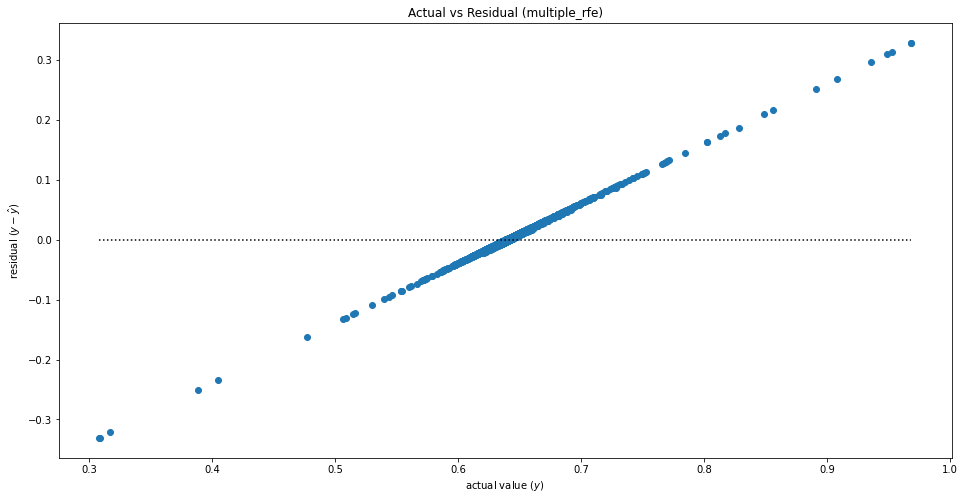

In [93]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster1_predictions.actual_logerror, cluster1_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [94]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (0.03 * calculatedbathnbr) + (-0.03 * fullbathcnt) + 0.64


In [95]:
ev.regression_errors(cluster1_predictions.actual_logerror, cluster1_predictions.multiple_rfe, cluster1_predictions)


SSE    2.939
ESS    0.002
TSS    2.941
MSE    0.000
RMSE   0.021
dtype: float64

In [96]:
cluster1_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster1_predictions.actual_logerror, c)))


actual_logerror     0.000
baseline_logerror   0.021
multiple_rfe        0.021
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [97]:
ev.better_than_baseline(cluster1_predictions.actual_logerror, cluster1_predictions.multiple_rfe, cluster1_predictions.baseline_logerror, cluster1_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

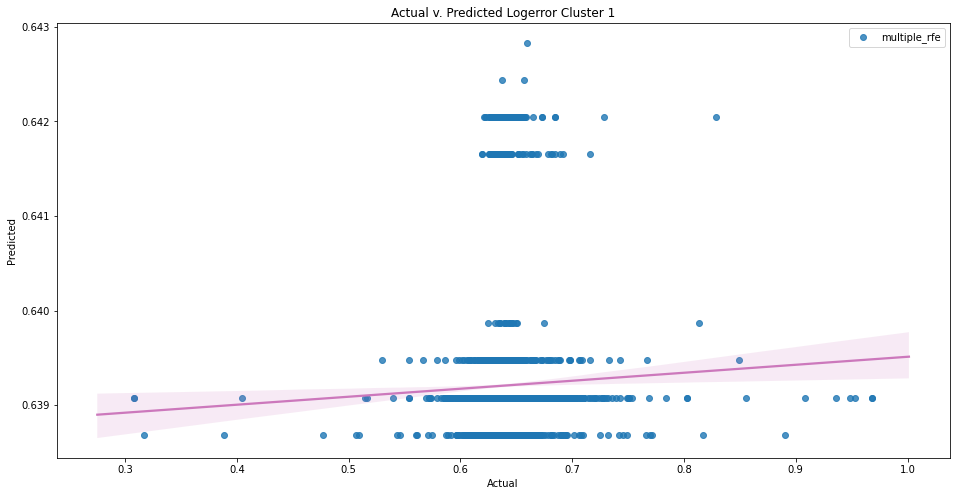

In [98]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster1_predictions.actual_logerror, y=cluster1_predictions.multiple_rfe, data=cluster1_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 1")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 2 Model: RFE

In [99]:
X = size_cluster2.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster2.logerror

In [100]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [101]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['landtaxvaluedollarcnt', 'yard_size'], dtype='object')


In [102]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.25627464, 0.27785387],
       [0.2915387 , 0.32072888],
       [0.03691032, 0.30506759],
       ...,
       [0.21197624, 0.44786518],
       [0.0762893 , 0.4796046 ],
       [0.03280185, 0.50300721]])

In [103]:
cluster2_predictions = pd.DataFrame({
    "actual_logerror": size_cluster2.logerror,
    "baseline_logerror": size_cluster2.logerror.mean()
})

cluster2_predictions.head()

,actual_logerror,baseline_logerror
31907,0.634,0.641
22827,0.643,0.641
35579,0.641,0.641
13835,0.645,0.641
5000,0.635,0.641


In [104]:
lm.fit(X_rfe, y)
cluster2_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster2_predictions

,actual_logerror,baseline_logerror,multiple_rfe
31907,0.634,0.641,0.642
22827,0.643,0.641,0.641
35579,0.641,0.641,0.643
13835,0.645,0.641,0.643
5000,0.635,0.641,0.640
...,...,...,...
35961,0.668,0.641,0.639
11402,0.630,0.641,0.641
37464,0.639,0.641,0.641
17220,0.672,0.641,0.641


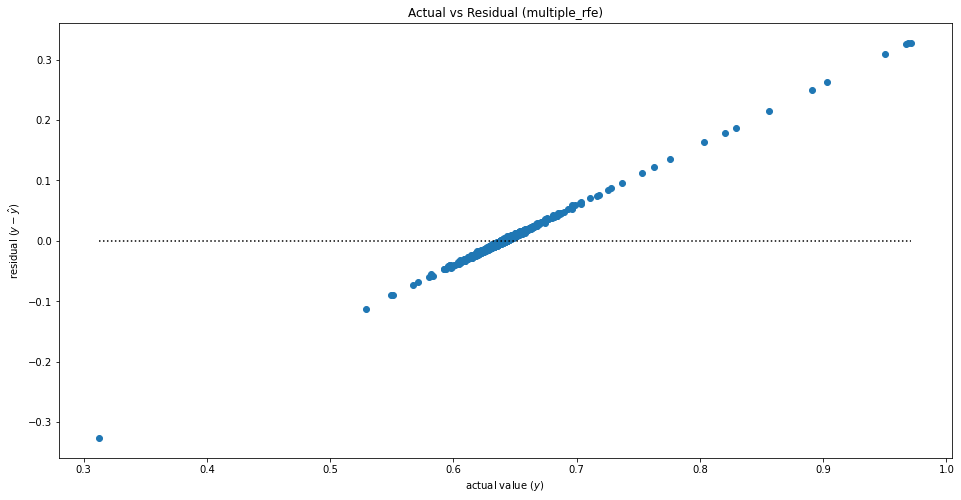

In [105]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster2_predictions.actual_logerror, cluster2_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [106]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (-0.01 * landtaxvaluedollarcnt) + (-0.01 * yard_size) + 0.65


In [107]:
ev.regression_errors(cluster2_predictions.actual_logerror, cluster2_predictions.multiple_rfe, cluster2_predictions)


SSE    1.175
ESS    0.003
TSS    1.178
MSE    0.001
RMSE   0.026
dtype: float64

In [108]:
cluster2_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster2_predictions.actual_logerror, c)))


actual_logerror     0.000
baseline_logerror   0.026
multiple_rfe        0.026
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [109]:
ev.better_than_baseline(cluster2_predictions.actual_logerror, cluster2_predictions.multiple_rfe, cluster2_predictions.baseline_logerror, cluster2_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

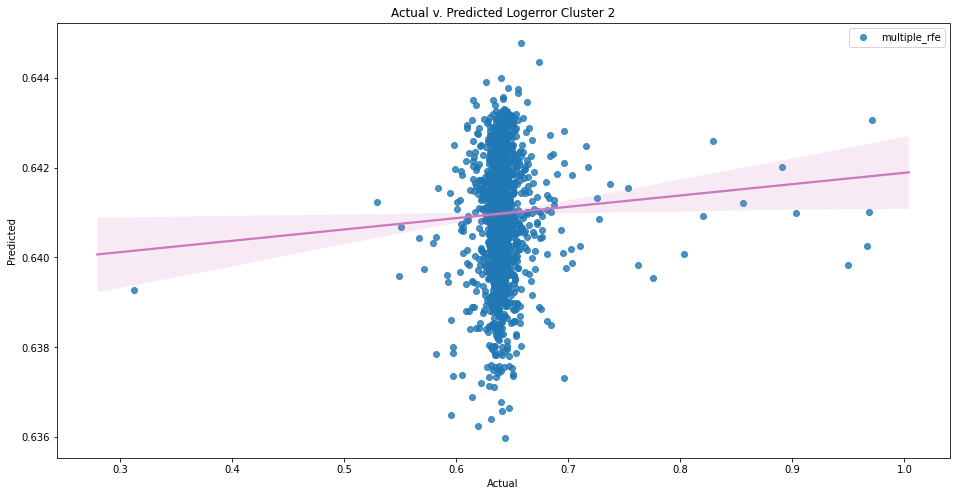

In [110]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster2_predictions.actual_logerror, y=cluster2_predictions.multiple_rfe, data=cluster2_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 2")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 3 Model: RFE

In [111]:
X = size_cluster3.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster3.logerror

In [112]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [113]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['bathroomcnt', 'calculatedbathnbr'], dtype='object')


In [114]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.2, 0.2],
       [0.2, 0.2],
       [0. , 0. ],
       ...,
       [0.2, 0.2],
       [0.4, 0.4],
       [0. , 0. ]])

In [115]:
cluster3_predictions = pd.DataFrame({
    "actual_logerror": size_cluster3.logerror,
    "baseline_logerror": size_cluster3.logerror.mean()
})

cluster3_predictions.head()

,actual_logerror,baseline_logerror
13143,0.633,0.639
5357,0.632,0.639
21808,0.638,0.639
924,0.632,0.639
32929,0.660,0.639


In [116]:
lm.fit(X_rfe, y)
cluster3_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster3_predictions

,actual_logerror,baseline_logerror,multiple_rfe
13143,0.633,0.639,0.639
5357,0.632,0.639,0.639
21808,0.638,0.639,0.638
924,0.632,0.639,0.639
32929,0.660,0.639,0.638
...,...,...,...
25861,0.651,0.639,0.639
34769,0.661,0.639,0.639
40069,0.638,0.639,0.639
23934,0.638,0.639,0.640


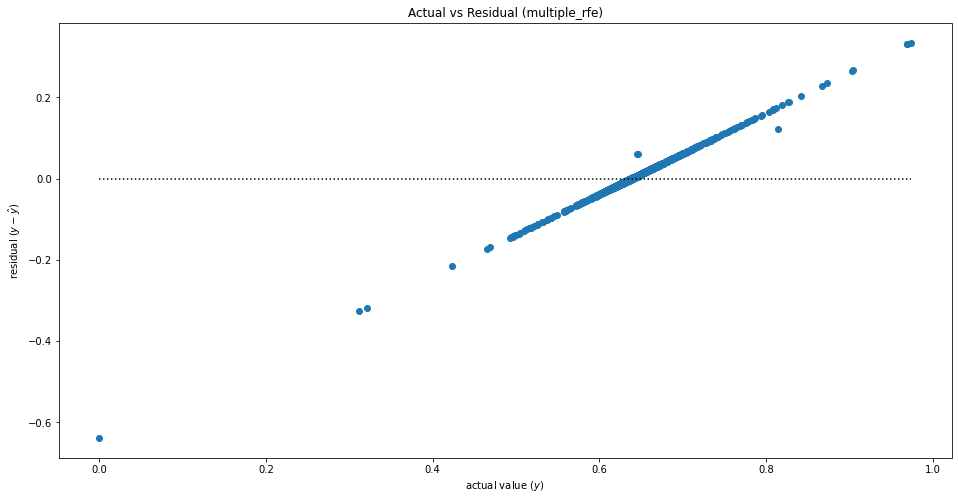

In [117]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster3_predictions.actual_logerror, cluster3_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [118]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (0.54 * bathroomcnt) + (-0.54 * calculatedbathnbr) + 0.64


In [119]:
ev.regression_errors(cluster3_predictions.actual_logerror, cluster3_predictions.multiple_rfe, cluster3_predictions)


SSE    4.185
ESS    0.010
TSS    4.195
MSE    0.001
RMSE   0.023
dtype: float64

In [120]:
cluster3_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster3_predictions.actual_logerror, c)))


actual_logerror     0.000
baseline_logerror   0.023
multiple_rfe        0.023
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [121]:
ev.better_than_baseline(cluster3_predictions.actual_logerror, cluster3_predictions.multiple_rfe, cluster3_predictions.baseline_logerror, cluster3_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

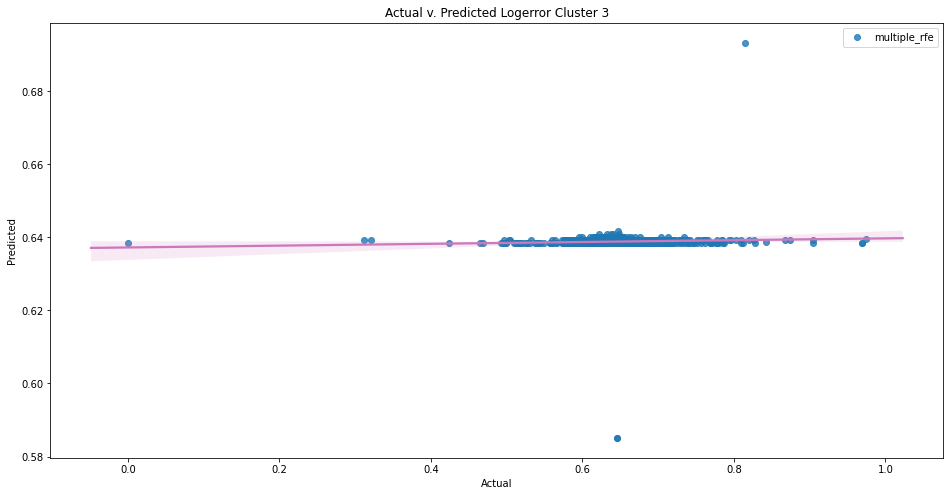

In [122]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster3_predictions.actual_logerror, y=cluster3_predictions.multiple_rfe, data=cluster3_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 4 Model: RFE

In [123]:
X = size_cluster4.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster4.logerror

In [124]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [125]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['bathroomcnt', 'calculatedbathnbr'], dtype='object')


In [126]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.9, 0.9],
       [0.6, 0.6],
       [0.4, 0.4],
       ...,
       [0.3, 0.3],
       [0.4, 0.4],
       [0.4, 0.4]])

In [127]:
cluster4_predictions = pd.DataFrame({
    "actual_logerror": size_cluster4.logerror,
    "baseline_logerror": size_cluster4.logerror.mean()
})

cluster4_predictions.head()

,actual_logerror,baseline_logerror
20902,0.633,0.642
27863,0.636,0.642
23139,0.655,0.642
6838,0.638,0.642
40142,0.644,0.642


In [128]:
lm.fit(X_rfe, y)
cluster4_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster4_predictions

,actual_logerror,baseline_logerror,multiple_rfe
20902,0.633,0.642,0.648
27863,0.636,0.642,0.644
23139,0.655,0.642,0.642
6838,0.638,0.642,0.642
40142,0.644,0.642,0.642
...,...,...,...
10876,0.639,0.642,0.642
6630,0.635,0.642,0.644
40098,0.641,0.642,0.640
19021,0.641,0.642,0.642


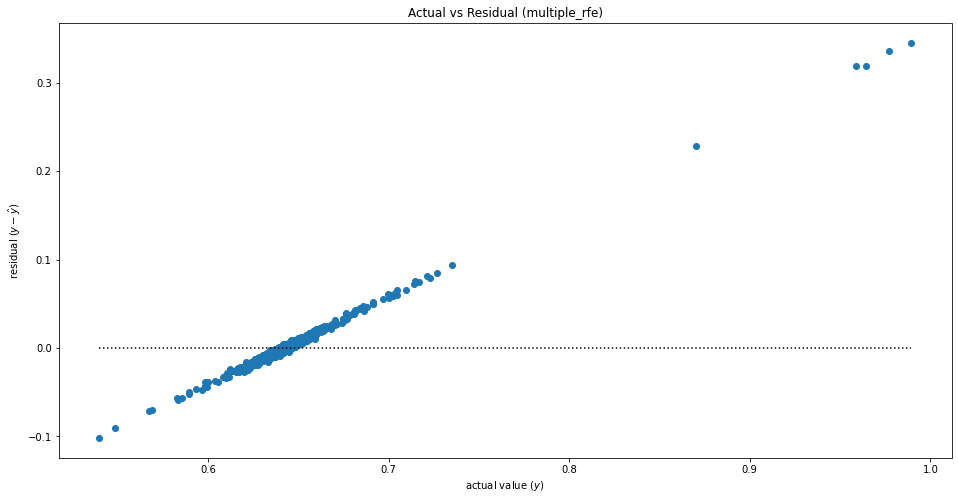

In [129]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster4_predictions.actual_logerror, cluster4_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [130]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (2046547933807.22 * bathroomcnt) + (-2046547933807.21 * calculatedbathnbr) + 0.64


In [131]:
ev.regression_errors(cluster4_predictions.actual_logerror, cluster4_predictions.multiple_rfe, cluster4_predictions)


SSE    0.773
ESS    0.004
TSS    0.778
MSE    0.001
RMSE   0.027
dtype: float64

In [132]:
cluster4_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster4_predictions.actual_logerror, c)))


actual_logerror     0.000
baseline_logerror   0.027
multiple_rfe        0.027
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [133]:
ev.better_than_baseline(cluster4_predictions.actual_logerror, cluster4_predictions.multiple_rfe, cluster4_predictions.baseline_logerror, cluster4_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

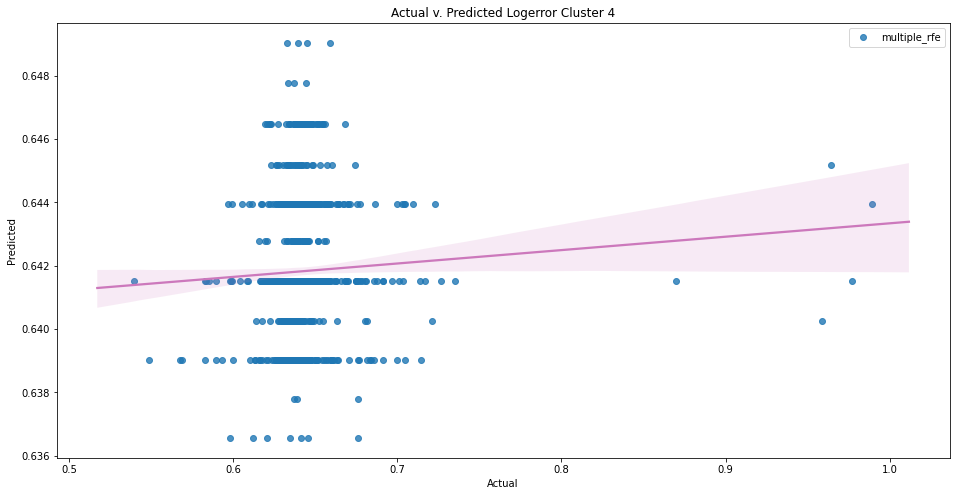

In [134]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster4_predictions.actual_logerror, y=cluster4_predictions.multiple_rfe, data=cluster4_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 4")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 5 Model: RFE

In [135]:
X = size_cluster5.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster5.logerror

In [136]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [137]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['bathroomcnt', 'structuretaxvaluedollarcnt'], dtype='object')


In [138]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.5       , 0.36783438],
       [0.3       , 0.32824409],
       [0.4       , 0.14180843],
       ...,
       [0.3       , 0.23077004],
       [0.2       , 0.16219378],
       [0.4       , 0.31061255]])

In [139]:
cluster5_predictions = pd.DataFrame({
    "actual_logerror": size_cluster5.logerror,
    "baseline_logerror": size_cluster5.logerror.mean()
})

cluster5_predictions.head()

,actual_logerror,baseline_logerror
16790,0.637,0.640
19144,0.640,0.640
36446,0.647,0.640
9856,0.634,0.640
32078,0.639,0.640


In [140]:
lm.fit(X_rfe, y)
cluster5_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster5_predictions

,actual_logerror,baseline_logerror,multiple_rfe
16790,0.637,0.640,0.642
19144,0.640,0.640,0.640
36446,0.647,0.640,0.641
9856,0.634,0.640,0.638
32078,0.639,0.640,0.640
...,...,...,...
31167,0.618,0.640,0.642
12931,0.639,0.640,0.638
25016,0.639,0.640,0.640
39151,0.644,0.640,0.639


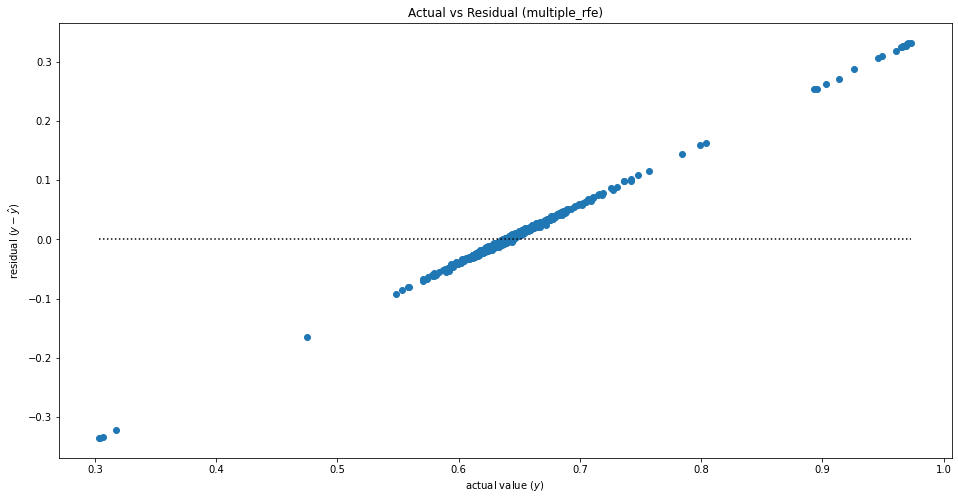

In [141]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster5_predictions.actual_logerror, cluster5_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [142]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (0.01 * bathroomcnt) + (-0.00 * structuretaxvaluedollarcnt) + 0.64


In [143]:
ev.regression_errors(cluster5_predictions.actual_logerror, cluster5_predictions.multiple_rfe, cluster5_predictions)


SSE    3.039
ESS    0.007
TSS    3.046
MSE    0.001
RMSE   0.026
dtype: float64

In [144]:
cluster5_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster5_predictions.actual_logerror, c)))


actual_logerror     0.000
baseline_logerror   0.026
multiple_rfe        0.026
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [145]:
ev.better_than_baseline(cluster5_predictions.actual_logerror, cluster5_predictions.multiple_rfe, cluster5_predictions.baseline_logerror, cluster5_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

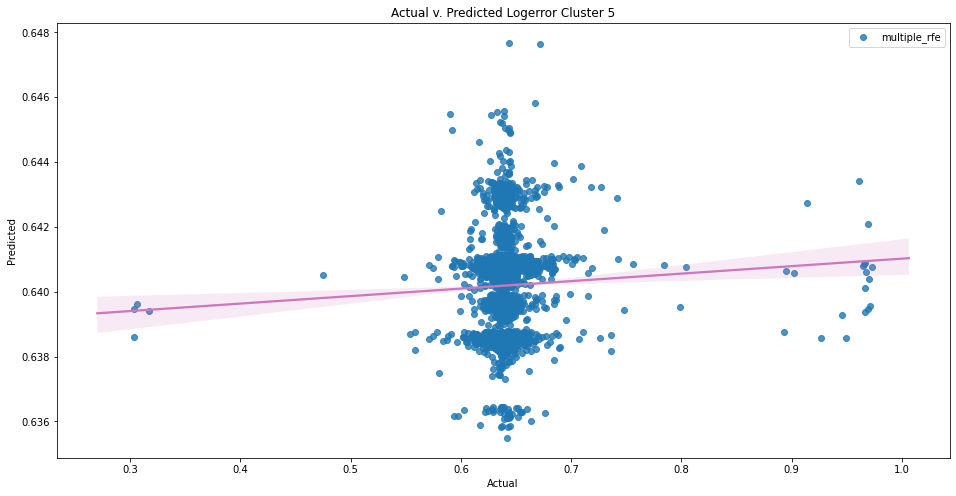

In [146]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster5_predictions.actual_logerror, y=cluster5_predictions.multiple_rfe, data=cluster5_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 5")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Size Cluster 6 Model: RFE

In [147]:
X = size_cluster6.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster6.logerror

In [148]:
k = 2
lm = sklearn.linear_model.LinearRegression()

In [149]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 2 features: Index(['bathroomcnt', 'fullbathcnt'], dtype='object')


In [150]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.2, 0.2],
       [0.4, 0.4],
       [0.2, 0.2],
       ...,
       [0.2, 0.2],
       [0.2, 0.2],
       [0.4, 0.4]])

In [151]:
cluster6_predictions = pd.DataFrame({
    "actual_logerror": size_cluster6.logerror,
    "baseline_logerror": size_cluster6.logerror.mean()
})

cluster6_predictions.head()

,actual_logerror,baseline_logerror
4219,0.631,0.640
27364,0.632,0.640
1720,0.619,0.640
6913,0.631,0.640
14920,0.625,0.640


In [152]:
lm.fit(X_rfe, y)
cluster6_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster6_predictions

,actual_logerror,baseline_logerror,multiple_rfe
4219,0.631,0.640,0.640
27364,0.632,0.640,0.639
1720,0.619,0.640,0.640
6913,0.631,0.640,0.639
14920,0.625,0.640,0.640
...,...,...,...
30195,0.633,0.640,0.640
32748,0.634,0.640,0.639
20528,0.642,0.640,0.640
18470,0.694,0.640,0.640


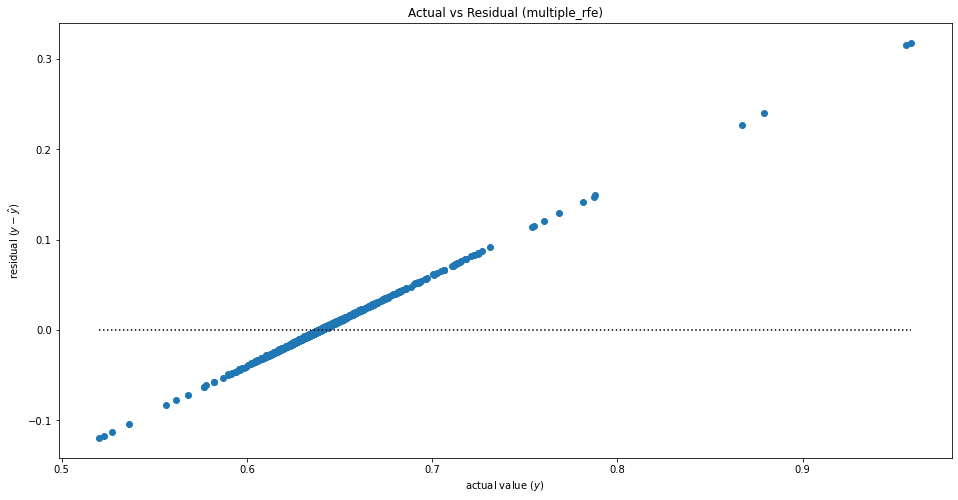

In [153]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster6_predictions.actual_logerror, cluster6_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [154]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (-0.01 * bathroomcnt) + (0.01 * fullbathcnt) + 0.64


In [155]:
ev.regression_errors(cluster6_predictions.actual_logerror, cluster6_predictions.multiple_rfe, cluster6_predictions)


SSE    1.038
ESS    0.000
TSS    1.038
MSE    0.000
RMSE   0.020
dtype: float64

In [156]:
cluster6_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster6_predictions.actual_logerror, c)))


actual_logerror     0.000
baseline_logerror   0.020
multiple_rfe        0.020
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [157]:
ev.better_than_baseline(cluster6_predictions.actual_logerror, cluster6_predictions.multiple_rfe, cluster6_predictions.baseline_logerror, cluster6_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

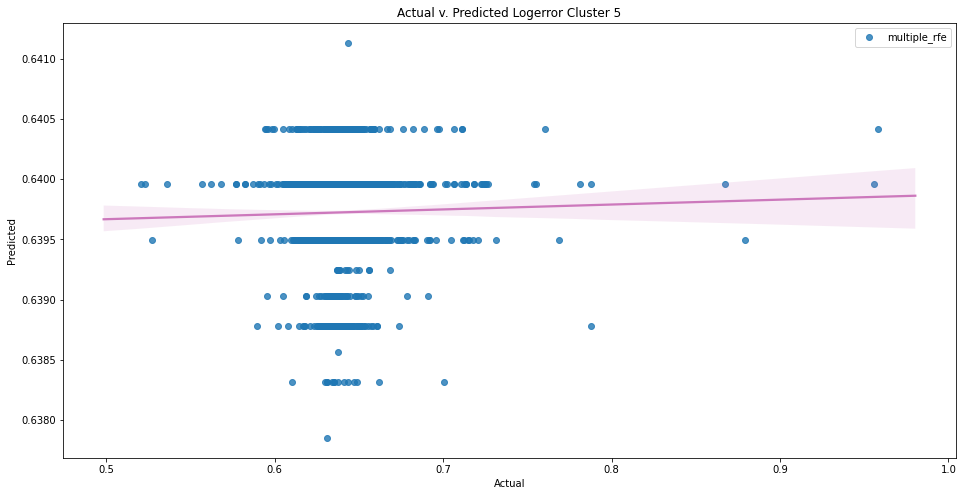

In [158]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster6_predictions.actual_logerror, y=cluster6_predictions.multiple_rfe, data=cluster6_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror Cluster 5")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()